In [2]:
#Install Required Libraries
#!pip install PyPDF2 spacy pandas numpy matplotlib seaborn scikit-learn sentence-transformers pytesseract pdf2image

# Install the SpaCy model
#!python -m spacy download en_core_web_sm
#!pip install wordcloud nltk

# Download WordNet data
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
import numpy as np
import pandas as pd
import os
import PyPDF2
import pytesseract
import re
import spacy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from wordcloud import WordCloud
from nltk.corpus import wordnet as wn
from collections import defaultdict

### 1. Data Cleansing and Preparation

In [5]:
# Load metadata
metadata = pd.read_csv('/workspaces/project-2-ombudsman/metadata.csv')

# Set the directories
base_folders = [
    #'/workspaces/project-2-ombudsman/12_23_insurance',
    #'/workspaces/project-2-ombudsman/01_24_insurance',
    #'/workspaces/project-2-ombudsman/02_24_insurance',
    #'/workspaces/project-2-ombudsman/03_24_insurance',
    '/workspaces/project-2-ombudsman/04_24_insurance',
    '/workspaces/project-2-ombudsman/05_24_insurance'
]

**Exclude words**

In [34]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Expanded custom stop words list
custom_stop_words = set([
    "say", "said", "investigate", "claim", "reclaim", "uphold", "not uphold", "time", "mean", "ask",
    "thing", "right", "day", "month", "year", "provide", "work", "consider", "include", "exclude", "report", "previous", "investigator",
    "follow", "decision", "ombudsman", "need", "feel", "felt", "believe", "may", "find", "refer", "item", "request", "give","gave",
    "point","lead", "new", "show", "use", "question", "happen", "happened", "view", "later",
    "tell", "told", "note", "look", "case", "base", "go", "going", "went", "event", "request", "whilst",
    "insurer", "available", "arrange", "handle", "take", "took", "receive", "send", "financial service", "ombudsman", "before", "after",
    "conclude", "comment", "require","required", "concern", "see","seen", "saw", "know", "set", "want", "carry","like", "likely", "decline", "act", 
    "conclusion", "result", "returne" "number", "appear","appeared", "record", "decide", "argument", "account", "way", "position", "appreciate",
    "explain", "compensation", "evidence", "apply","sorry", "apologies", "apology",
    "january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december", "hm", "deduct", 
    "can", "will", "would", "perhaps", "usually", "might", "could", "should", "shall", "is", "are", "was", "were", "be", "been",
    "have", "has", "had", "do", "does", "did", "get", "got", "make", "made", "see", "seen", "look", "looked", "direct","provisional",
    "know", "knew", "think", "thought", "understand", "understood", "date", "cause", "first", "limited", "Limited", "ltd","Ltd","begin", "end",
    "reason", "final", "policy", "customer", "pay", "simple", "total", "begin",
    "place", "insurance", "fact", "act", "how", "when", "what", "why", "when", "where", "which", "pounds"
])

# Function to get synonyms from WordNet
def get_synonyms(word):
    synonyms = set()
    for syn in wn.synsets(word):
        for l in syn.lemmas():
            synonyms.add(l.name().replace('_', ' ').lower())
    return synonyms

# Function to create synonym mapping for a list of words
def create_synonym_mapping(words):
    mapping = {}
    for word in words:
        synonyms = get_synonyms(word)
        representative = word  # You could also select the most common or central synonym
        for synonym in synonyms:
            mapping[synonym] = representative
    return mapping

# Generate synonym mapping for commonly important words in the domain
important_words = ['reason', 'final', 'policy','complaint', 'customer', 'recommendation', 'pay', 'decline', 'simple', 'total', 'begin', 'act', 'land', 'tax',
                   'impact', 'property', 'vehicle', 'life', 'travel', 'accident', 'issue', 'cover', 'not cover', 'increase', 'fair', 'unfair','investment', 
                   'wrong','correct', 'condition', 'inconvinience', 'agree', 'put', 'cash', 'interest', 'document', 'financial service', 'return',
                   'increase', 'decrease', 'appropriate', 'inappropriate', 'transparant', 'honest', 'unreveal', ' medical', 'disease', 'life', 'health']
synonym_mapping = create_synonym_mapping(important_words)

# Function to clean and replace synonyms in text
def clean_text_with_synonyms(text, synonym_mapping):
    doc = nlp(text)
    tokens = [
        synonym_mapping.get(token.lemma_.lower(), token.lemma_.lower())
        for token in doc
        if len(token.text) > 1
        and not token.is_stop and not token.is_punct
        and not any(char.isdigit() for char in token.text)
        and not re.match(r'^(Mr|Mrs|Miss|Ms)\.?', token.text)
        and token.lemma_.lower() not in custom_stop_words
    ]
    return ' '.join(tokens)


: 

**Standardise company name**

In [11]:
# Function to standardize company name
def standardize_company_name(company):
    company_mapping = {
        "Aviva Insurance Limited": "Aviva",
        "AXA Insurance UK Plc": "AXA",
        "Direct Line Insurance Group Plc": "Direct Line",
        "Zurich Insurance Plc": "Zurich",
        "Allianz Insurance Plc": "Allianz",
        "LV Insurance": "LV=",
        "Esure Insurance": "Esure",
        "Admiral Insurance": "Admiral",
        "Ageas Insurance": "Ageas",
        "RSA Insurance": "RSA",
        "Hiscox Insurance": "Hiscox",
        "NFU Mutual Insurance": "NFU Mutual",
        "Saga Insurance": "Saga",
        "Co-op Insurance": "Co-op",
        "Covea Insurance": "Covea",
        "Chubb Insurance": "Chubb",
        "Legal & General Insurance": "Legal & General",
        "Markerstudy Insurance": "Markerstudy",
        "Churchill Insurance": "Churchill",
        "Swinton Insurance": "Swinton",
        "Tesco Bank Insurance": "Tesco Bank",
        "Virgin Money Insurance": "Virgin Money",
        "John Lewis Insurance": "John Lewis",
        "Sainsbury's Insurance": "Sainsbury's",
        "Halifax Insurance": "Halifax",
        "Barclays Insurance": "Barclays",
        "HSBC Insurance": "HSBC",
        "Lloyds Bank Insurance": "Lloyds Bank",
        "Santander Insurance": "Santander",
        "Nationwide Insurance": "Nationwide",
        # Add other mappings as needed
    }
    company = company.strip()
    if company in company_mapping:
        return company_mapping[company]
    return company

#### 2. Natural Language Processing for Data Extraction: 

Textual data needs to be further
analysed to extract relevant information from each document, the data extracted can be
used as features for a downstream modelling task.

**Extract The Main Complaints**

In [31]:
# Function to extract text with PyPDF2
def extract_text_with_pypdf2(file_path):
    text = ''
    try:
        with open(file_path, 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            for page_num in range(len(reader.pages)):
                page_text = reader.pages[page_num].extract_text()
                if page_text:
                    text += page_text
    except Exception as e:
        print(f"Failed to extract text from {file_path} using PyPDF2: {e}")
    return text

# Function to extract main reason for the complaint
def extract_main_reason(text):
    doc = nlp(text)
    complaint_phrase = ""

    # Find the sentence containing the word "complain"
    for sent in doc.sents:
        if "complain" in sent.text.lower():
            complaint_phrase = sent
            break

    # Extract the main reason in up to 3 words
    main_reason = []
    found_complaint = False
    for token in complaint_phrase:
        # Look for the pattern indicating the complaint reason
        if found_complaint:
            if token.dep_ in ("amod", "acomp", "attr", "dobj", "pobj", "advmod", "ROOT") and token.text.lower() not in {"complain", "that"}:
                main_reason.append(token.text)
            if len(main_reason) >= 3:
                break
        if token.text.lower() == "complained" or token.lemma_.lower() == "complain":
            found_complaint = True

    return ' '.join(main_reason[:3])

# Function to process a single PDF file and extract main complaint reason
def process_pdf(file_path):
    text = extract_text_with_pypdf2(file_path)
    cleaned_text = clean_text_with_synonyms(text, synonym_mapping)
    main_reason = extract_main_reason(cleaned_text)
    return cleaned_text, main_reason

In [32]:
# Function to get metadata info
def get_metadata_info(filename):
    decision_id = re.search(r'DRN-(\d+)', filename).group(1)
    row = metadata[metadata['decision_id'].str.contains(decision_id)]
    if not row.empty:
        decision = row.iloc[0]['decision']
        company = row.iloc[0]['company']
        return decision, company
    else:
        return None, None

In [33]:
# Extract text from all PDFs in specified directories
def extract_text_from_pdfs(base_folders):
    pdf_texts = {}
    for base_folder in base_folders:
        for root, dirs, files in os.walk(base_folder):
            for filename in files:
                if filename.endswith('.pdf'):
                    file_path = os.path.join(root, filename)
                    text, main_reason = process_pdf(file_path)
                    pdf_texts[filename] = (text, main_reason)
                    print(f"Processed {filename} -> Main reason: {main_reason}")  # Debug print
    return pdf_texts

# Extract text from all PDFs
pdf_texts = extract_text_from_pdfs(base_folders)

# Create dataframe with cleaned texts and corresponding metadata
data = []
for filename, (text, main_reason) in pdf_texts.items():
    decision, company = get_metadata_info(filename)
    if decision and company:
        company = standardize_company_name(company)
        data.append((filename, text, decision, company, main_reason))

df = pd.DataFrame(data, columns=['filename', 'text', 'decision', 'company', 'complaint'])
df.head()

Processed 04_24_Insurance_DRN-4552609.pdf -> Main reason: europe
Processed 04_24_Insurance_DRN-4647254.pdf -> Main reason: appropriate appropriate legal
Processed 04_24_Insurance_DRN-4764947.pdf -> Main reason: commercial bring known
Processed 04_24_Insurance_DRN-4739493.pdf -> Main reason: legal royal i.e.
Processed 04_24_Insurance_DRN-4730514.pdf -> Main reason: national mutual mutual
Processed 04_24_Insurance_DRN-4645773.pdf -> Main reason: afresh fair fair
Processed 04_24_Insurance_DRN-4642425.pdf -> Main reason: legal general critical
Processed 04_24_Insurance_DRN-4514349.pdf -> Main reason: unable away poor
Processed 04_24_Insurance_DRN-4719007.pdf -> Main reason: cover judgement
Processed 04_24_Insurance_DRN-4767560.pdf -> Main reason: 
Processed 04_24_Insurance_DRN-4677820.pdf -> Main reason: premium short online
Processed 04_24_Insurance_DRN-4718559.pdf -> Main reason: 
Processed 04_24_Insurance_DRN-4747912.pdf -> Main reason: happy car happy
Processed 04_24_Insurance_DRN-4669

,filename,text,decision,company,complaint
0,04_24_Insurance_DRN-4552609.pdf,complaint complain axis specialty europe se ma...,Not upheld,AXIS Specialty Europe SE,europe
1,04_24_Insurance_DRN-4647254.pdf,complaint policyholder son name driver complai...,Not upheld,AXA,appropriate appropriate legal
2,04_24_Insurance_DRN-4764947.pdf,complaint complain arch uk arch subsidence com...,Upheld,Arch Insurance (UK) Limited,commercial bring known
3,04_24_Insurance_DRN-4739493.pdf,complaint complain royal sun alliance plc refu...,Not upheld,Royal & Sun Alliance Insurance Limited,legal royal i.e.
4,04_24_Insurance_DRN-4730514.pdf,complaint company complain national farmers un...,Upheld,The National Farmers' Union Mutual Insurance S...,national mutual mutual


**Feature Engineering**

In [16]:
# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['text'])
y = df['decision']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3. Exploratory Data Analysis (EDA)

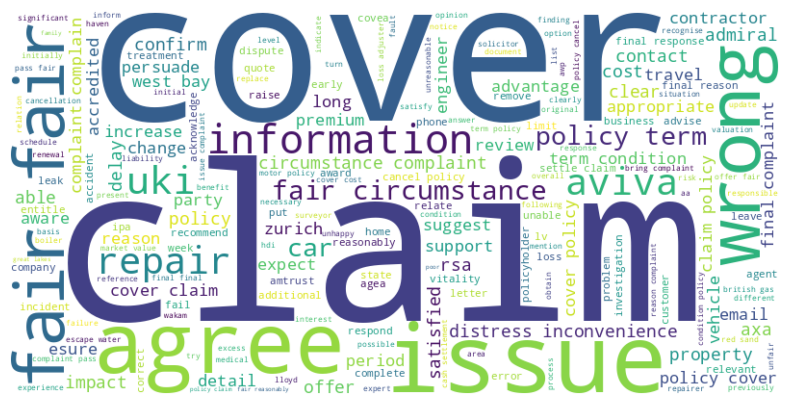

In [17]:
all_text = ' '.join(df['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

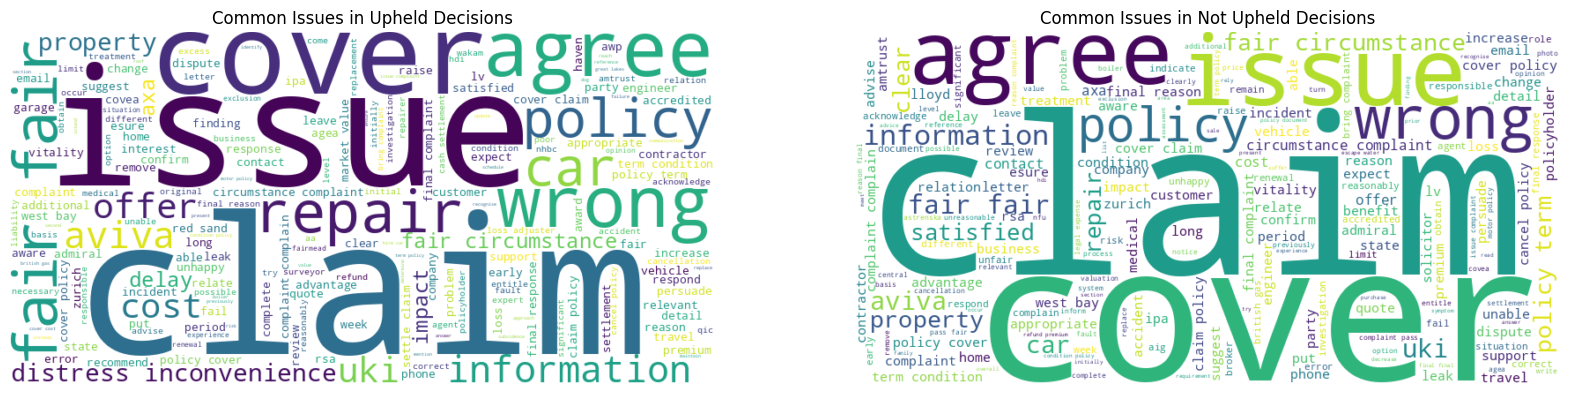

In [18]:
# explore common words that lead to decisions
def explore_common_word(df):
    # Identify common issues in upheld decisions
    upheld_issues = df[df['decision'] == 'Upheld']['text']
    wordcloud_upheld = WordCloud(width=800, height=400, background_color='white').generate(' '.join(upheld_issues))

    # Identify common issues in not upheld decisions
    not_upheld_issues = df[df['decision'] == 'Not upheld']['text']
    wordcloud_not_upheld = WordCloud(width=800, height=400, background_color='white').generate(' '.join(not_upheld_issues))

    plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud_upheld, interpolation='bilinear')
    plt.title('Common Issues in Upheld Decisions')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud_not_upheld, interpolation='bilinear')
    plt.title('Common Issues in Not Upheld Decisions')
    plt.axis('off')

    plt.show()
    
explore_common_word(df)

#### **1. Common Issues in Upheld Decisions:**

**Frequent Terms:** 
The most prominent terms in upheld decisions include "cover," "fair," "reasonable," "circumstance," "agree," "property," "vehicle," "clear," "delay," "support," and "repair."

**Main Themes:**

**Coverage Disputes:** Issues related to coverage ("cover") appear frequently, suggesting that many complaints revolve around whether the policy adequately covered certain events or damages.
**Fairness and Reasonableness:** Terms like "fair," "reasonable," and "circumstance" indicate that many upheld complaints may involve the insurer's judgment being deemed unfair or unreasonable.
**Property and Vehicles:** The frequent mention of "property" and "vehicle" implies that many upheld complaints involve claims related to property damage or vehicle issues.
**Communication and Delays:** Words such as "clear," "delay," and "support" suggest that communication issues and delays in handling claims are common reasons for upholding complaints.

#### **2. Common Issues in Not Upheld Decisions:**

**Frequent Terms:** 
The most prominent terms in not upheld decisions include "information," "agree," "fair," "reasonable," "cover," "circumstance," "property," "repair," "contact," "cost," and "support."

**Main Themes:**

**Information and Documentation:** The term "information" is prominent, suggesting that complaints were not upheld due to insufficient or incomplete information provided by the complainant.
**Agreement on Terms:** The terms "agree" and "fair" suggest that, in these cases, the insurer's decisions were found to be fair and consistent with the policy terms.
**Coverage and Costs:** Similar to upheld decisions, "cover" and "cost" indicate ongoing disputes about coverage and costs, but these were resolved in favor of the insurer.
**Communication:** Words like "contact" and "support" point to communication aspects, but the insurer's actions were deemed appropriate in these cases.
Recommendations:
Improve Communication and Transparency:

**Clear Documentation:** Ensure all communications and documentation provided to policyholders are clear and comprehensive to reduce misunderstandings.
Proactive Updates: Regularly update customers on the status of their claims to reduce complaints about delays and unclear processes.
Review and Adjust Policy Coverage:

Comprehensive Coverage: Review policy terms to ensure they provide adequate coverage for common complaints, especially for property and vehicle-related claims.
Transparent Terms: Make policy terms more transparent and easily understandable to prevent disputes about coverage.
Training for Fair Decision-Making:

Employee Training: Train claim handlers on fair and reasonable decision-making to ensure consistency and fairness in handling claims.
Guidelines: Develop clear guidelines and frameworks to help employees make fair and transparent decisions.
Enhance Support and Customer Service:

Customer Support: Strengthen customer support services to assist policyholders better throughout the claims process.
Issue Resolution: Implement robust mechanisms for resolving issues promptly to avoid escalations to complaints.
Focus on Common Dispute Areas:

Property and Vehicle Claims: Pay special attention to property and vehicle claims, as these are common sources of disputes.
Fairness in Assessments: Ensure assessments and decisions about claims are perceived as fair by conducting regular reviews and audits.
By addressing these key areas, insurers can reduce the number of complaints, improve customer satisfaction, and enhance the overall quality of their products and services.

### 4. Visualization

decision
Not upheld    432
Upheld        407
Name: count, dtype: int64


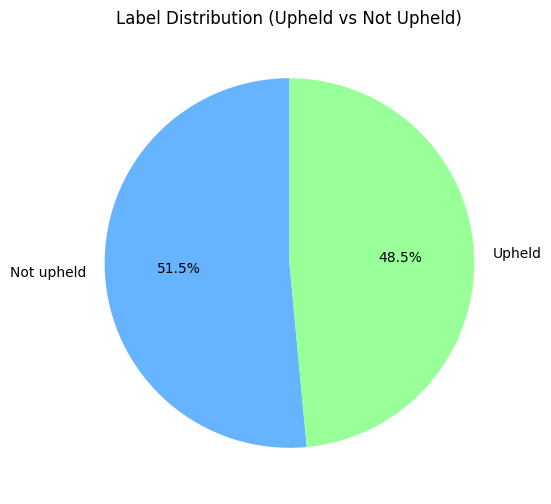

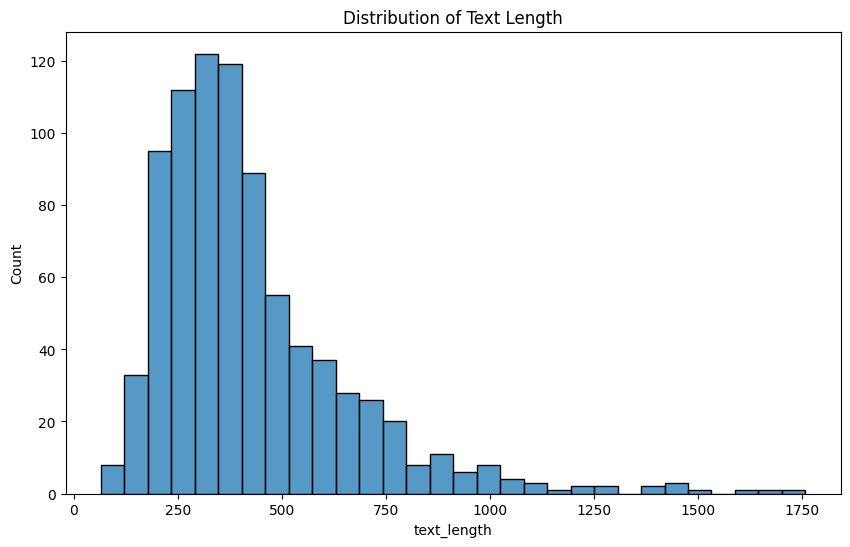

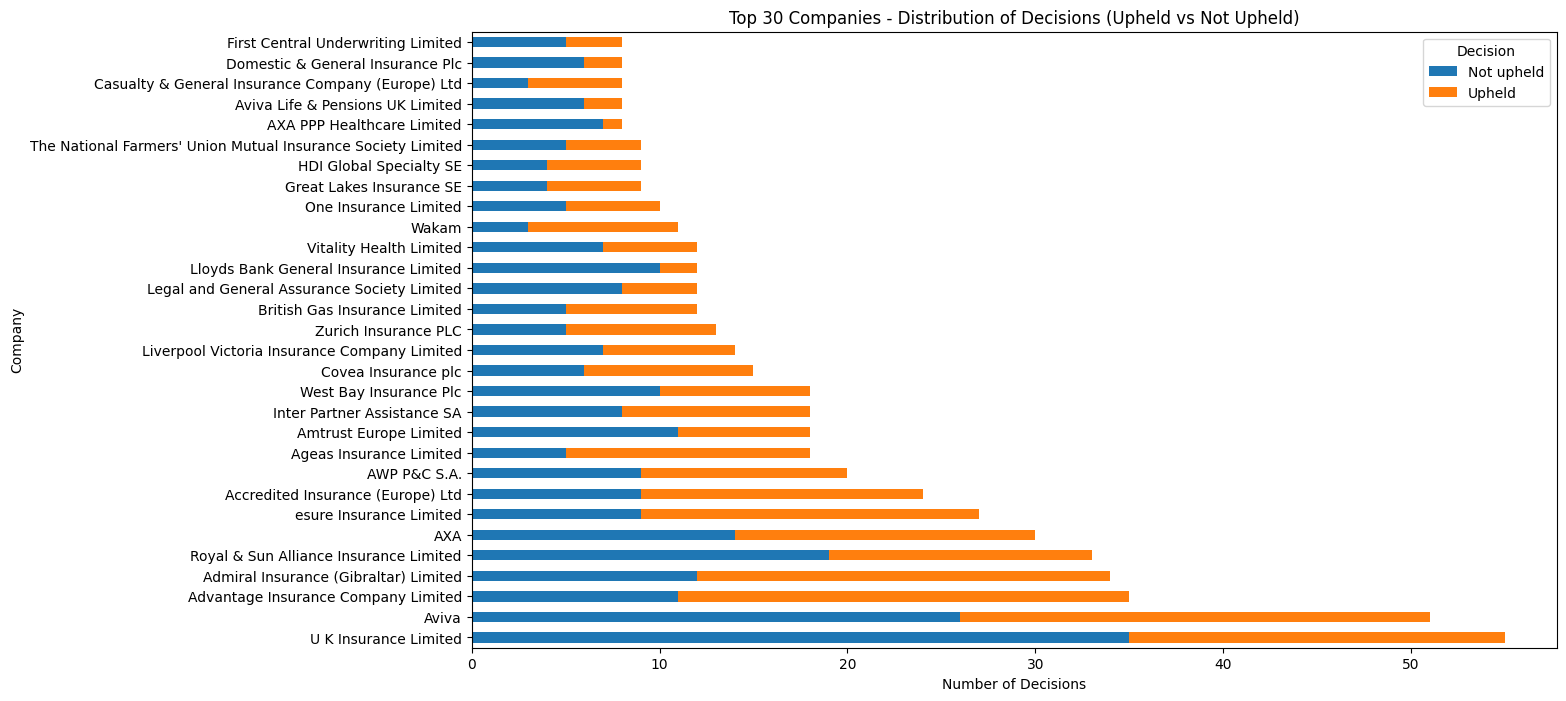

In [19]:
# Basic statistics
print(df['decision'].value_counts())

# Visualize the label distribution with a pie chart
plt.figure(figsize=(8, 6))
df['decision'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#99ff99'])
plt.title('Label Distribution (Upheld vs Not Upheld)')
plt.ylabel('')  # Hide the y-label for better appearance
plt.show()

# Length of text analysis
df['text_length'] = df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=30)
plt.title('Distribution of Text Length')
plt.show()

# Aggregate decision counts by company
company_decision_counts = df.groupby(['company', 'decision']).size().unstack().fillna(0)

# Select the top 20 companies based on the total number of decisions
top_30_companies = company_decision_counts.sum(axis=1).nlargest(30).index
top_30_decision_counts = company_decision_counts.loc[top_30_companies]

# Plot stacked horizontal bar chart
top_30_decision_counts.plot(kind='barh', stacked=True, figsize=(14, 8))

plt.ylabel('Company')
plt.xlabel('Number of Decisions')
plt.title('Top 30 Companies - Distribution of Decisions (Upheld vs Not Upheld)')
plt.legend(title='Decision', loc='upper right')
plt.show()



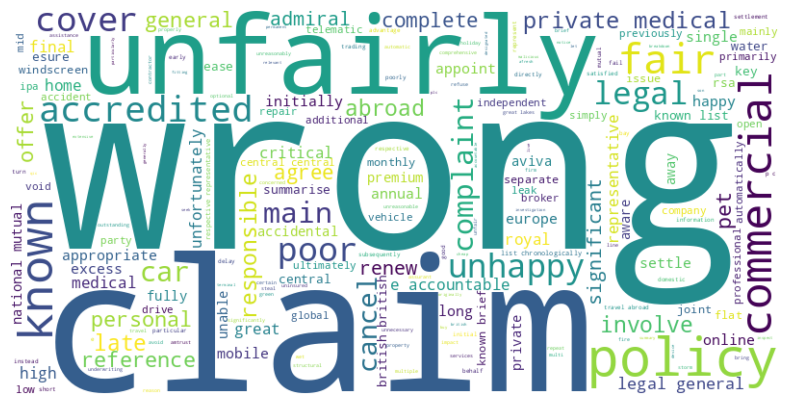

In [20]:
complain = ' '.join(df['complaint'])
wordcloud_C = WordCloud(width=800, height=400, background_color='white').generate(complain)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_C, interpolation='bilinear')
plt.axis('off')
plt.show()

### 6. Prediction of Claim Outcome with Hyperparameter Tuning

#### A. Logistic Regression Model

In [21]:
# Hyperparameter tuning for Logistic Regression
param_grid_lr = {'C': [10, 50, 100, 150]}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, refit=True, verbose=2)
grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ...............................................C=10; total time=   0.1s
[CV] END ...............................................C=10; total time=   0.0s
[CV] END ...............................................C=10; total time=   0.0s
[CV] END ...............................................C=10; total time=   0.0s
[CV] END ...............................................C=10; total time=   0.0s
[CV] END ...............................................C=50; total time=   0.0s
[CV] END ...............................................C=50; total time=   0.0s
[CV] END ...............................................C=50; total time=   0.0s
[CV] END ...............................................C=50; total time=   0.0s
[CV] END ...............................................C=50; total time=   0.0s
[CV] END ..............................................C=100; total time=   0.0s
[CV] END ........................................

GridSearchCV(estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [10, 50, 100, 150]}, verbose=2)

In [22]:
# Best parameters from GridSearchCV for Logistic Regression
print("Best parameters for Logistic Regression:", grid_lr.best_params_)

# Predictions and evaluation for Logistic Regression
y_pred_lr = grid_lr.predict(X_test)
print("Logistic Regression Classifier (TF-IDF):")
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))

Best parameters for Logistic Regression: {'C': 100}
Logistic Regression Classifier (TF-IDF):
              precision    recall  f1-score   support

  Not upheld       0.77      0.82      0.79        87
      Upheld       0.79      0.74      0.76        81

    accuracy                           0.78       168
   macro avg       0.78      0.78      0.78       168
weighted avg       0.78      0.78      0.78       168

[[71 16]
 [21 60]]


#### B. Decision Tree Model

In [23]:
# Hyperparameter tuning for Decision Tree
param_grid_dt = {'criterion': ['gini', 'entropy'], 'max_depth': [10, 20, 30, 40, 50], 'min_samples_split': [2, 5, 10]}
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, refit=True, verbose=2)
grid_dt.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END ..criterion=gini, max_depth=10, min_samples_split=2; total time=   0.1s
[CV] END ..criterion=gini, max_depth=10, min_samples_split=2; total time=   0.1s
[CV] END ..criterion=gini, max_depth=10, min_samples_split=2; total time=   0.1s
[CV] END ..criterion=gini, max_depth=10, min_samples_split=2; total time=   0.1s
[CV] END ..criterion=gini, max_depth=10, min_samples_split=2; total time=   0.1s
[CV] END ..criterion=gini, max_depth=10, min_samples_split=5; total time=   0.1s
[CV] END ..criterion=gini, max_depth=10, min_samples_split=5; total time=   0.1s
[CV] END ..criterion=gini, max_depth=10, min_samples_split=5; total time=   0.1s
[CV] END ..criterion=gini, max_depth=10, min_samples_split=5; total time=   0.1s
[CV] END ..criterion=gini, max_depth=10, min_samples_split=5; total time=   0.1s
[CV] END .criterion=gini, max_depth=10, min_samples_split=10; total time=   0.1s
[CV] END .criterion=gini, max_depth=10, min_sam

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 30, 40, 50],
                         'min_samples_split': [2, 5, 10]},
             verbose=2)

In [24]:
# Best parameters from GridSearchCV for Decision Tree
print("Best parameters for Decision Tree:", grid_dt.best_params_)

# Predictions and evaluation for Decision Tree
y_pred_dt = grid_dt.predict(X_test)
print("Decision Tree Classifier (TF-IDF):")
print(classification_report(y_test, y_pred_dt))
print(confusion_matrix(y_test, y_pred_dt))

Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 40, 'min_samples_split': 2}
Decision Tree Classifier (TF-IDF):
              precision    recall  f1-score   support

  Not upheld       0.71      0.69      0.70        87
      Upheld       0.67      0.69      0.68        81

    accuracy                           0.69       168
   macro avg       0.69      0.69      0.69       168
weighted avg       0.69      0.69      0.69       168

[[60 27]
 [25 56]]


#### C. Random Forest Model

In [25]:
# Hyperparameter tuning for Random Forest
param_grid_rf = {'n_estimators': [200, 300, 400], 'max_features': ['auto', 'sqrt']}
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, refit=True, verbose=2)
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ................max_features=auto, n_estimators=200; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=200; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=200; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=200; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=200; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=300; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=300; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=300; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=300; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=300; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=400; total time=   0.0s
[CV] END ................max_features=auto, n_est

/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/c

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_features': ['auto', 'sqrt'],
                         'n_estimators': [200, 300, 400]},
             verbose=2)

In [26]:
# Best parameters from GridSearchCV for Random Forest
print("Best parameters for Random Forest:", grid_rf.best_params_)

# Predictions and evaluation for Random Forest
y_pred_rf = grid_rf.predict(X_test)
print("Random Forest Classifier (TF-IDF):")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

Best parameters for Random Forest: {'max_features': 'sqrt', 'n_estimators': 400}
Random Forest Classifier (TF-IDF):
              precision    recall  f1-score   support

  Not upheld       0.83      0.83      0.83        87
      Upheld       0.81      0.81      0.81        81

    accuracy                           0.82       168
   macro avg       0.82      0.82      0.82       168
weighted avg       0.82      0.82      0.82       168

[[72 15]
 [15 66]]


### 7. Feature Importance

In [27]:
def get_synonym_group(word):
    synonyms = set()
    for syn in wn.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name().lower())
    return synonyms

def group_features_by_synonyms(features):
    grouped_features = {}
    for feature in features:
        synonyms = get_synonym_group(feature)
        found_group = False
        for group in grouped_features:
            if not synonyms.isdisjoint(grouped_features[group]):
                grouped_features[group].update(synonyms)
                grouped_features[group].add(feature)
                found_group = True
                break
        if not found_group:
            grouped_features[feature] = synonyms
            grouped_features[feature].add(feature)
    return grouped_features

# Assuming the feature importance plot data is available
importances = grid_rf.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
features = vectorizer.get_feature_names_out()

# Get top 20 features
top_features = [features[i] for i in indices[:20]]

# Group features by synonyms
grouped_features = group_features_by_synonyms(top_features)

# Print grouped features
for key, value in grouped_features.items():
    print(f"{key}: {', '.join(value)}")

inconvenience: worriment, disoblige, perturb, discommode, inconvenience, disorder, disquiet, distract, cark, pain, hassle, trouble_oneself, ail, bother, unhinge, put_out, worry, incommodiousness, inconvenience_oneself, trouble, difficulty, incommode, upset, problem, fuss, troublesomeness, disturb
interest: worry, interest, matter_to, interestingness, sake, interest_group, pastime, concern, stake, pursuit, involvement, occupy
distress: distraint, distress, straiten, hurt, suffering
pay: give-up_the_ghost, encompass, incubate, come_about, wage, decease, make_pass, bye, pay_off, address, insure, offer, go_through, cover, masking, mountain_pass, liberty_chit, overtake, exit, snuff_it, transcend, choke, fall_out, pay, go_past, travel_by, remuneration, egest, track, hand, go_on, handle, hap, laissez_passer, brood, authorize, plow, elapse, enshroud, head, top, slide_by, cover_up, run, cut_across, give, traverse, reach, croak, extend, overcompensate, pas, go, concealment, cross, get_over, elim

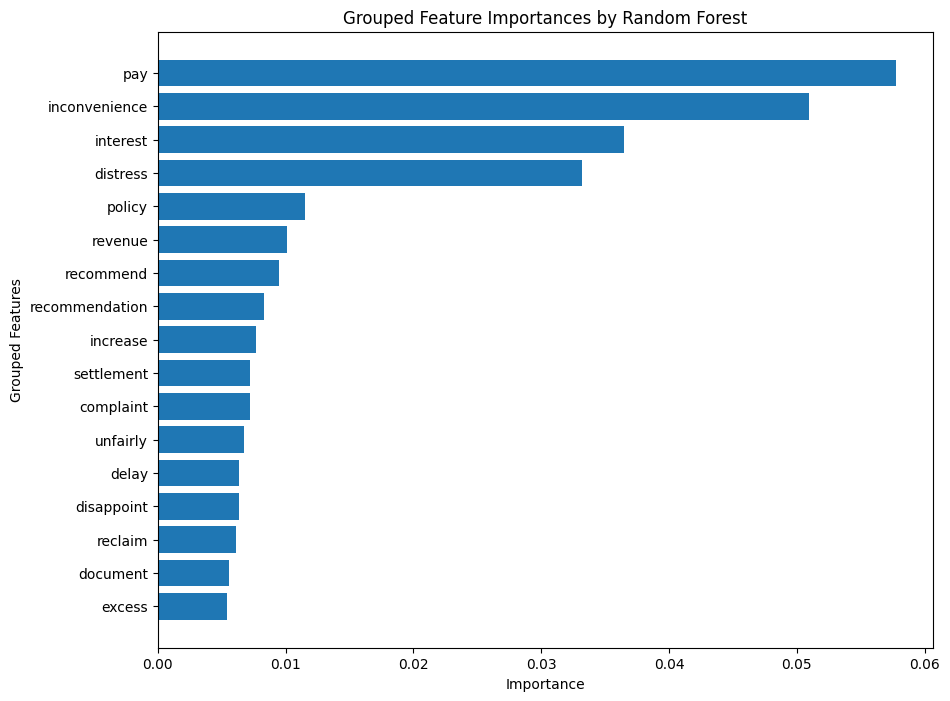

In [28]:
# Aggregate importances for grouped features
grouped_importances = defaultdict(float)
for feature, synonyms in grouped_features.items():
    for synonym in synonyms:
        if synonym in features:
            idx = list(features).index(synonym)
            grouped_importances[feature] += importances[idx]

# Sort grouped features by their aggregated importance
sorted_grouped_importances = sorted(grouped_importances.items(), key=lambda x: x[1], reverse=True)

# Plot grouped feature importances
plt.figure(figsize=(10, 8))
plt.title("Grouped Feature Importances by Random Forest")
plt.barh(range(len(sorted_grouped_importances)), [importance for _, importance in sorted_grouped_importances], align="center")
plt.yticks(range(len(sorted_grouped_importances)), [feature for feature, _ in sorted_grouped_importances])
plt.xlabel('Importance')
plt.ylabel('Grouped Features')
plt.gca().invert_yaxis()  # To display the highest importance feature at the top
plt.show()
